## 載入套件

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit,GridSearchCV
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import tree
import seaborn as sns
from sklearn.tree import export_graphviz # 導出為dot 文件 
from subprocess import call 
from IPython.display import Image 
from sklearn.neighbors import KNeighborsClassifier

## 匯入資料 且做scaler

In [ ]:
from google.colab import drive
import os 
from google.colab import drive
drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks' # The folder path that contain this ipynb
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive',GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH,'data_0513_月頻_新增技術指標.csv'),encoding = 'utf-8')

data = data.iloc[1:,:].reset_index(drop=True).drop('date',axis = 1)
data

train_X = data.iloc[:127,1:].reset_index(drop=True)
test_X = data.iloc[127:,1:].reset_index(drop=True)

features_names = train_X.columns
target_names = 'target_mom'
train_Y = data['target_mom'].iloc[:127].reset_index(drop=True)
test_Y = data['target_mom'].iloc[127:].reset_index(drop=True)

Mounted at /content/drive


In [ ]:
MMS = MinMaxScaler()
train_X = MMS.fit_transform(train_X)
test_X = MMS.fit_transform(test_X)

tscv = TimeSeriesSplit(n_splits=5,test_size=12)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=12)

## 隨機森林

In [ ]:
RFclf = RandomForestClassifier(n_estimators=100)
RFclf.fit(train_X, train_Y)
y_pred = RFclf.predict(test_X)

In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred, test_Y)*100:.2f}%")
print(f"AUC score: {metrics.roc_auc_score(test_Y,y_pred)*100:.2f}%")
print(f"Confusion Matrix:\n {confusion_matrix(y_pred, test_Y)}")

Train Result:

Accuracy Score: 52.08%
Precision Score: 76.19%
Recall Score: 47.06%
F1 score: 58.18%
AUC score: 54.76%
Confusion Matrix:
 [[ 9  5]
 [18 16]]


In [ ]:
hyperparameter_space = {'n_estimators':[5,10,20,30], 
              'max_depth':[2,3,4,5,6,7,8,9],
              "min_samples_split" : [2,3,4,5,6,7,8,9,10],
              "min_samples_leaf" : [2,3,4,5,6,7,8,9,10]
              }


rs_RFclf = GridSearchCV(RFclf, param_grid=hyperparameter_space,
                        scoring="accuracy",n_jobs=-1, cv=tscv)

rs_RFclf.fit(train_X, train_Y)
print("最佳參數組合 :" ,rs_RFclf.best_params_)

最佳參數組合 : {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 9, 'n_estimators': 10}


In [ ]:
hyperparameter_space = {'n_estimators':[5,10,20,30], 
              'max_depth':[2,3,4,5,6,7,8,9],
              "min_samples_split" : [2,3,4,5,6,7,8,9,10],
              "min_samples_leaf" : [2,3,4,5,6,7,8,9,10]
              }


rs_RFclf = GridSearchCV(RFclf, param_grid=hyperparameter_space,
                        scoring="accuracy",n_jobs=-1, cv=tscv)

rs_RFclf.fit(train_X, train_Y)
print("最佳參數組合 :" ,rs_RFclf.best_params_)

RFclf_bestparam = RandomForestClassifier(
    min_samples_split = rs_RFclf.best_params_["min_samples_split"],
    min_samples_leaf = rs_RFclf.best_params_["min_samples_leaf"],
    max_depth = rs_RFclf.best_params_["max_depth"],
    n_estimators = rs_RFclf.best_params_["n_estimators"])


RFclf_bestparam.fit(train_X,train_Y)
y_pred_RF = RFclf_bestparam.predict(test_X)

print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_RF, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_RF, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_RF, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_RF, test_Y)*100:.2f}%")
print('AUC: %.4f' % metrics.roc_auc_score(test_Y,y_pred_RF))
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_RF, test_Y)}")

最佳參數組合 : {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 5}
Train Result:

Accuracy Score: 58.33%
Precision Score: 76.19%
Recall Score: 51.61%
F1 score: 61.54%
AUC: 0.6032
Confusion Matrix:
 [[12  5]
 [15 16]]


In [ ]:
import pickle

In [ ]:
model_name = os.path.join(GOOGLE_DRIVE_PATH,'random_forest.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(RFclf_bestparam, modelfile)

In [ ]:
model_name = os.path.join(GOOGLE_DRIVE_PATH,'random_forest.sav')
with open(model_name, 'rb') as f:
    rfclf = pickle.load(f)

print(rfclf)

RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=3,
                       n_estimators=5)


In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_RF, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_RF, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_RF, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_RF, test_Y)*100:.2f}%")
print('AUC: %.4f' % metrics.roc_auc_score(test_Y,y_pred_RF))
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_RF, test_Y)}")

Train Result:

Accuracy Score: 56.25%
Precision Score: 76.19%
Recall Score: 50.00%
F1 score: 60.38%
AUC: 0.5847
Confusion Matrix:
 [[11  5]
 [16 16]]


In [ ]:
!pip install shap
import shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.3 MB/s 


In [ ]:
explainer = shap.TreeExplainer(rfclf)
shap_values = explainer.shap_values(train_X)

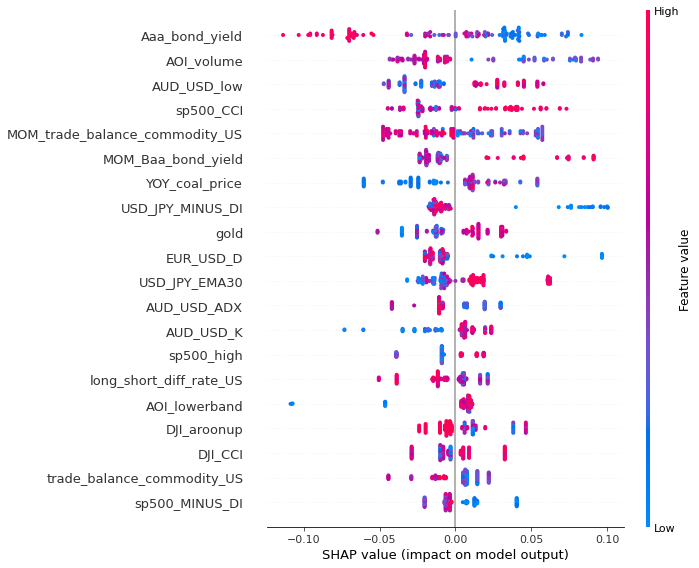

In [ ]:
shap.summary_plot(shap_values[0], train_X,feature_names = features_names)

## svm

In [ ]:
clf=svm.SVC(kernel = 'linear')
clf.fit(train_X,train_Y)
pred_y = clf.predict(test_X)
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(pred_y, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(pred_y, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(pred_y, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(pred_y, test_Y)*100:.2f}%")
print ('AUC: %.4f' % metrics.roc_auc_score(test_Y,pred_y))
print(f"Confusion Matrix:\n {confusion_matrix(pred_y, test_Y)}")

Train Result:

Accuracy Score: 56.25%
Precision Score: 85.71%
Recall Score: 50.00%
F1 score: 63.16%
AUC: 0.5952
Confusion Matrix:
 [[ 9  3]
 [18 18]]


In [ ]:
param_grid = {'C': [0.1,1, 10, 1000, 10000],
              'gamma': [3,2,1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

clf = svm.SVC()
svm_clf = GridSearchCV(clf,param_grid,cv = tscv,verbose=1,scoring='accuracy')
svm_clf.fit(train_X,train_Y)
print("最佳參數組合 :" ,svm_clf.best_params_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
最佳參數組合 : {'C': 1000, 'gamma': 0.1, 'kernel': 'sigmoid'}


In [ ]:
SVMclf_bestparam = svm.SVC(
    C = svm_clf.best_params_["C"],
    gamma = svm_clf.best_params_["gamma"],
    kernel = 'linear',
    probability= True)

SVMclf_bestparam.fit(train_X,train_Y)
y_pred_svm = SVMclf_bestparam.predict(test_X)

In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_svm, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_svm, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_svm, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_svm, test_Y)*100:.2f}%")
print('AUC: %.4f' % metrics.roc_auc_score(test_Y,y_pred_svm))
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_svm, test_Y)}")

Train Result:

Accuracy Score: 56.25%
Precision Score: 90.48%
Recall Score: 50.00%
F1 score: 64.41%
AUC: 0.6005
Confusion Matrix:
 [[ 8  2]
 [19 19]]


## KNN

In [ ]:
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(train_X,train_Y)
y_pred_knn = KNN_clf.predict(test_X)
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_knn, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_knn, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_knn, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_knn, test_Y)*100:.2f}%")
print ('AUC: %.4f' % metrics.roc_auc_score(test_Y,y_pred_knn))
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_knn, test_Y)}")

Train Result:

Accuracy Score: 52.08%
Precision Score: 71.43%
Recall Score: 46.88%
F1 score: 56.60%
AUC: 0.5423
Confusion Matrix:
 [[10  6]
 [17 15]]


In [ ]:
KNN_clf = KNeighborsClassifier(n_neighbors = 1)

parameters_KNN = {
    'n_neighbors': [1, 2,3,4, 5, 10],
    'leaf_size': [1,2,3,4,5, 10, 20, 40],
    'p': [1,2,3,4],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'chebyshev']
    }

KNN_clf = GridSearchCV(KNN_clf, parameters_KNN, n_jobs=-1, cv=tscv)
KNN_clf.fit(train_X,train_Y)
print("最佳參數組合 :" ,KNN_clf.best_params_)

最佳參數組合 : {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 4, 'weights': 'uniform'}


In [ ]:
KNN_clf_bestparam = KNeighborsClassifier(
    n_neighbors = KNN_clf.best_params_["n_neighbors"],
    leaf_size = KNN_clf.best_params_["leaf_size"],
    p = KNN_clf.best_params_["p"],
    weights = KNN_clf.best_params_["weights"],
    metric = KNN_clf.best_params_["metric"]
)

KNN_clf_bestparam.fit(train_X,train_Y)
y_pred_KNN = KNN_clf_bestparam.predict(test_X)

In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_KNN, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_KNN, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_KNN, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_KNN, test_Y)*100:.2f}%")
print ('AUC: %.4f' % metrics.roc_auc_score(test_Y,y_pred_KNN))
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_KNN, test_Y)}")

Train Result:

Accuracy Score: 58.33%
Precision Score: 76.19%
Recall Score: 51.61%
F1 score: 61.54%
AUC: 0.6032
Confusion Matrix:
 [[12  5]
 [15 16]]


In [ ]:
import pickle

In [ ]:
model_name = os.path.join(GOOGLE_DRIVE_PATH,'KNN.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(KNN_clf_bestparam, modelfile)

In [ ]:
with open(model_name, 'rb') as f:
    load_model = pickle.load(f)

print(load_model)

KNeighborsClassifier(leaf_size=1, n_neighbors=3, p=4)


In [ ]:
shap.initjs()
# Get the model explainer object
explainer = shap.KernelExplainer(KNN_clf_bestparam.predict_proba, train_X)

# Get shap values for the test data observation whose index is 0, i.e. first observation in the test set
shap_values = explainer.shap_values(train_X)

# Generate a force plot for this first observation using the derived shap values
shap.force_plot(explainer.expected_value[0], shap_values[0], train_X)

Using 127 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/127 [00:00<?, ?it/s]

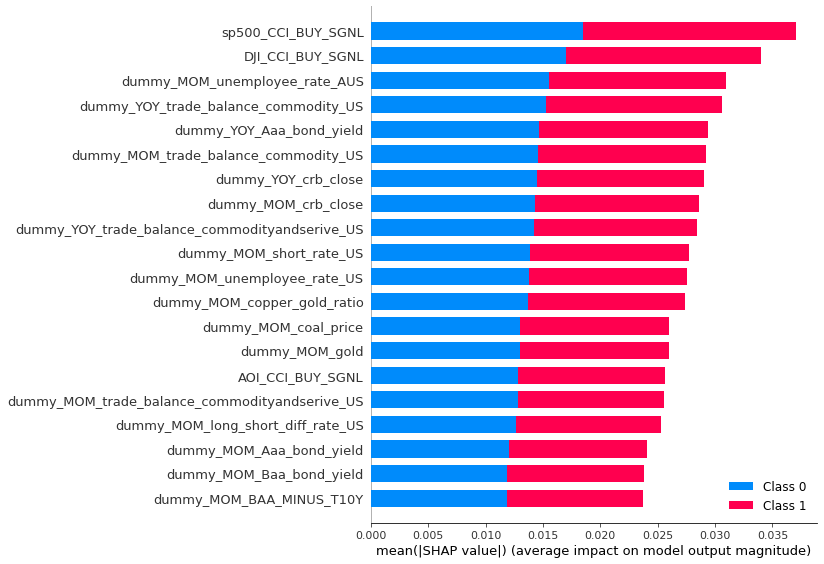

In [ ]:
shap.summary_plot(shap_values, train_X,feature_names = features_names)

## xgboost

In [ ]:
parameter_space = {
    'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':0.1,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.05,
    'nthread':8
}


clf = xgb.XGBClassifier(**parameter_space,use_label_encoder = False)

XGBclf_bestparam = clf.fit(train_X,train_Y)
pred_y_xgb = XGBclf_bestparam.predict(test_X)

print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(pred_y_xgb, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(pred_y_xgb, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(pred_y_xgb, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(pred_y_xgb, test_Y)*100:.2f}%")
print ('AUC: %.4f' % metrics.roc_auc_score(test_Y,pred_y_xgb))
print(f"Confusion Matrix:\n {confusion_matrix(pred_y_xgb, test_Y)}")

Train Result:

Accuracy Score: 54.17%
Precision Score: 85.71%
Recall Score: 48.65%
F1 score: 62.07%
AUC: 0.5767
Confusion Matrix:
 [[ 8  3]
 [19 18]]


In [ ]:
hyperparameter_space = {
        'max_depth': [2,3,5,9,15],
        'learning_rate': [0.001,0.0001],
        'subsample': [0.5,0.7,0.8,0.9],
        'colsample_bytree': [0.5,0.7,0.8,0.9],
        'min_child_weight': [2,5,7],
        'lambda':[0.1,0.2,0.3],
        'gamma':[0.001,0.002,0.005],
        'subsample' : [0.5,0.7,0.8],
        'n_estimators': [3,5,10,15,30,50],
        'objective': ['binary:logistic'],
        'eval_metric' : ['accuracy']}

fit_params = {'early_stopping_rounds' : 100,
        'eval_metric' : 'error',
        'eval_set' : [[test_X,test_Y]]
        }

CLF = xgb.XGBClassifier(use_label_encoder = False)


rs_xgb = GridSearchCV(CLF, hyperparameter_space,
          cv=tscv.get_n_splits([train_X,train_Y]),
          scoring='accuracy',n_jobs=-1,verbose=2)


rs_xgb.fit(train_X,train_Y, **fit_params)
print("最佳參數組合 :" ,rs_xgb.best_params_)

Fitting 5 folds for each of 19440 candidates, totalling 97200 fits
[0]	validation_0-error:0.645833
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.354167
[2]	validation_0-error:0.4375
最佳參數組合 : {'colsample_bytree': 0.9, 'eval_metric': 'accuracy', 'gamma': 0.001, 'lambda': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 3, 'objective': 'binary:logistic', 'subsample': 0.7}


In [ ]:
XGBclf_bestparam = xgb.XGBClassifier(
    max_depth = rs_xgb.best_params_["max_depth"],
    learning_rate = rs_xgb.best_params_["learning_rate"],
    subsample = rs_xgb.best_params_["subsample"],
    colsample_bytree = rs_xgb.best_params_["colsample_bytree"],
    min_child_weight = rs_xgb.best_params_["min_child_weight"],
    gamma = rs_xgb.best_params_["gamma"],
    n_estimators = rs_xgb.best_params_["n_estimators"],
    objective = rs_xgb.best_params_['objective'],use_label_encoder = False)


XGBclf_bestparam.fit(train_X,train_Y)
y_pred_xgb = XGBclf_bestparam.predict(test_X)

In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_xgb, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_xgb, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_xgb, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_xgb, test_Y)*100:.2f}%")
print('AUC: %.4f' % metrics.roc_auc_score(test_Y,y_pred_xgb))
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_xgb, test_Y)}")

Train Result:

Accuracy Score: 56.25%
Precision Score: 47.62%
Recall Score: 50.00%
F1 score: 48.78%
AUC: 0.5529
Confusion Matrix:
 [[17 11]
 [10 10]]


In [ ]:
import pickle

In [ ]:
model_name = os.path.join(GOOGLE_DRIVE_PATH,'xgboost.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(XGBclf_bestparam, modelfile)

In [ ]:
with open(model_name, 'rb') as f:
    load_model = pickle.load(f)

print(load_model)

XGBClassifier(colsample_bytree=0.9, gamma=0.001, learning_rate=0.001,
              min_child_weight=2, missing=nan, n_estimators=3, subsample=0.7,
              use_label_encoder=False)


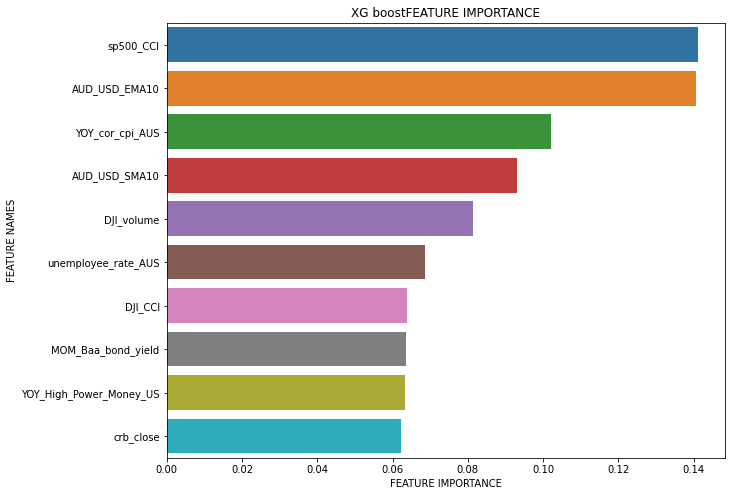

In [ ]:
def plot_feature_importance(importance,names,model_type):
#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'].head(10), y=fi_df['feature_names'].head(10))
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(XGBclf_bestparam.feature_importances_,features_names,'XG boost')

## Stacking model (RF + SVM + XGboost)

In [ ]:
pip install mlrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [ ]:
#Stacking
from mlxtend.classifier import StackingClassifier

meta_estimator = XGBclf_bestparam
stacking = StackingClassifier(classifiers=[SVMclf_bestparam, RFclf_bestparam,  KNN_clf_bestparam, MLP_clf_bestparam], meta_classifier=meta_estimator, use_probas=True, average_probas = False)

for model in [SVMclf_bestparam, RFclf_bestparam,  KNN_clf_bestparam, MLP_clf_bestparam, stacking]:
    model.fit(train_X,train_Y)
    y_pred = model.predict(test_X)
    print(model.__class__.__name__, 'test accuracy', accuracy_score(test_Y,y_pred))


stacking.fit(train_X,train_Y)
y_pred_stacking = stacking.predict(test_X)

SVC test accuracy 0.48641975308641977
RandomForestClassifier test accuracy 0.5185185185185185
KNeighborsClassifier test accuracy 0.4773662551440329
MLPClassifier test accuracy 0.508641975308642
StackingClassifier test accuracy 0.502880658436214


In [ ]:
metrics.roc_auc_score(test_Y,stacking.predict_proba(test_X)[:, 1])

0.49831591896901184

In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(y_pred_stacking, test_Y)*100:.2f}%")
print(f"Precision Score: {precision_score(y_pred_stacking, test_Y)*100:.2f}%")
print(f"Recall Score: {recall_score(y_pred_stacking, test_Y)*100:.2f}%")
print(f"F1 score: {f1_score(y_pred_stacking, test_Y)*100:.2f}%")
print(f"Confusion Matrix:\n {confusion_matrix(y_pred_stacking, test_Y)}")

Train Result:

Accuracy Score: 50.29%
Precision Score: 48.28%
Recall Score: 50.60%
F1 score: 49.41%
Confusion Matrix:
 [[316 316]
 [288 295]]


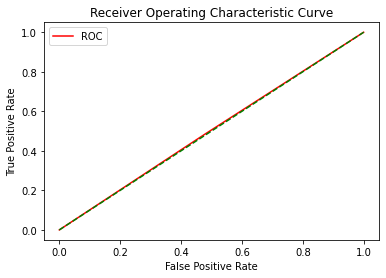

In [ ]:
fper, tper, thresholds = metrics.roc_curve(test_Y, y_pred_stacking)
plot_roc_curve(fper, tper)

## # 我們畫出決策邊界

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

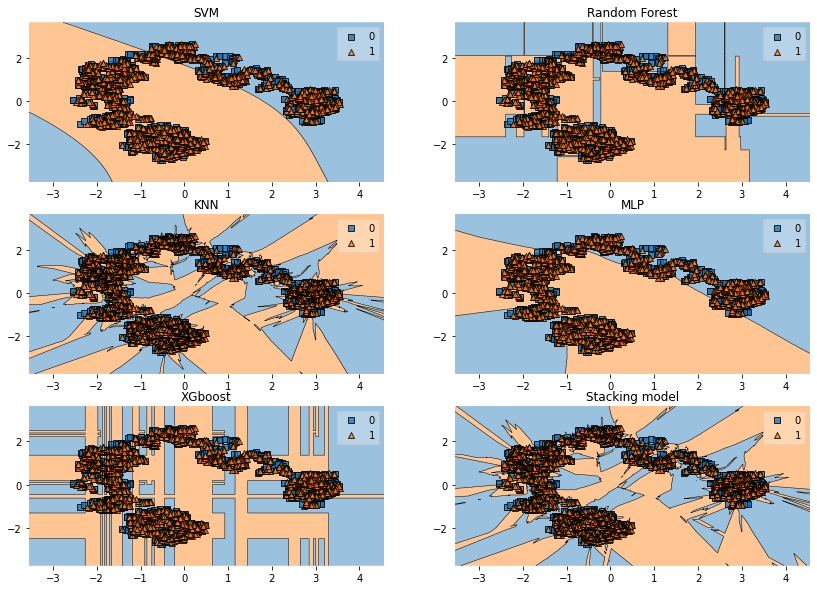

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
train_x_pca = pca.fit_transform(train_X)

gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(14,10))
for clf, lab, grd in zip([SVMclf_bestparam, RFclf_bestparam, KNN_clf_bestparam, MLP_clf_bestparam, XGBclf_bestparam,stacking], 
                         ['SVM', 
                          'Random Forest', 
                          'KNN',
                          'MLP',
                          'XGboost',
                          'Stacking model'],
                          [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]):
    clf.fit(train_x_pca, train_Y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=train_x_pca, y=train_Y.values, clf=clf)
    plt.title(lab)
plt.show()

## LSTM

In [ ]:
import tensorflow as tf  
tf.compat.v1.disable_v2_behavior() 

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
from tensorflow import keras
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization

In [ ]:
train_X = data.iloc[:127,1:].reset_index(drop=True)
test_X = data.iloc[127:,1:].reset_index(drop=True)

features_names = train_X.columns
target_names = 'target_mom'
train_Y = data['target_mom'].iloc[:127].reset_index(drop=True)
test_Y = data['target_mom'].iloc[127:].reset_index(drop=True)

In [ ]:
target_feature = ['target_mom']
cat_features = ['target_mom','dummy_YOY_nonfarm_US',
 'dummy_YOY_cor_cpi_US',
 'dummy_YOY_trade_balance_commodity_US',
 'dummy_YOY_trade_balance_commodityandserive_US',
 'dummy_YOY_coal_price',
 'dummy_YOY_High_Power_Money_US',
 'dummy_YOY_unemployee_rate_US',
 'dummy_YOY_unemployee_rate_AUS',
 'dummy_YOY_short_rate_AUS',
 'dummy_YOY_cor_cpi_AUS',
 'dummy_MOM_nonfarm_US',
 'dummy_MOM_cor_cpi_US',
 'dummy_MOM_trade_balance_commodity_US',
 'dummy_MOM_trade_balance_commodityandserive_US',
 'dummy_MOM_coal_price',
 'dummy_MOM_High_Power_Money_US',
 'dummy_MOM_unemployee_rate_US',
 'dummy_MOM_unemployee_rate_AUS',
 'dummy_MOM_short_rate_AUS',
 'dummy_MOM_cor_cpi_AUS',
 'dummy_YOY_short_rate_US',
 'dummy_YOY_long_rate_US',
 'dummy_YOY_long_short_diff_rate_US',
 'dummy_YOY_crb_close',
 'dummy_YOY_Baa_bond_yield',
 'dummy_YOY_Aaa_bond_yield',
 'dummy_YOY_gold',
 'dummy_YOY_copper',
 'dummy_YOY_copper_gold_ratio',
 'dummy_YOY_BAA_MINUS_T10Y',
 'dummy_MOM_short_rate_US',
 'dummy_MOM_long_rate_US',
 'dummy_MOM_long_short_diff_rate_US',
 'dummy_MOM_crb_close',
 'dummy_MOM_Baa_bond_yield',
 'dummy_MOM_Aaa_bond_yield',
 'dummy_MOM_gold',
 'dummy_MOM_copper',
 'dummy_MOM_copper_gold_ratio',
 'dummy_MOM_BAA_MINUS_T10Y',
 'AUD_USD_KD_goldencross',
 'AUD_USD_KD_deadcross',
 'AUD_USD_BBAND_BUY_SGNL',
 'AUD_USD_BBAND_SELL_SGNL',
 'AUD_USD_AROON_BUY_SGNL',
 'AUD_USD_AROON_SELL_SGNL',
 'AUD_USD_SMA_BUY_SGNL',
 'AUD_USD_SMA_SELL_SGNL',
 'AUD_USD_EMA_BUY_SGNL',
 'AUD_USD_EMA_SELL_SGNL',
 'AUD_USD_ADX_BUY_SGNL',
 'AUD_USD_ADX_SELL_SGNL',
 'AUD_USD_RSI_BUY_SGNL',
 'AUD_USD_RSI_SELL_SGNL',
 'AUD_USD_CCI_BUY_SGNL',
 'AUD_USD_CCI_SELL_SGNL',
 'EUR_USD_KD_goldencross',
 'EUR_USD_KD_deadcross', 'USD_JPY_KD_goldencross',
 'USD_JPY_KD_deadcross', 'sp500_KD_goldencross',
 'sp500_KD_deadcross', 'AOI_KD_goldencross',
 'AOI_KD_deadcross', 'DJI_KD_goldencross',
 'DJI_KD_deadcross', 'EUR_USD_BBAND_BUY_SGNL',
 'EUR_USD_BBAND_SELL_SGNL', 'USD_JPY_BBAND_BUY_SGNL',
 'USD_JPY_BBAND_SELL_SGNL', 'sp500_BBAND_BUY_SGNL',
 'sp500_BBAND_SELL_SGNL', 'AOI_BBAND_BUY_SGNL',
 'AOI_BBAND_SELL_SGNL', 'DJI_BBAND_BUY_SGNL',
 'DJI_BBAND_SELL_SGNL','EUR_USD_AROON_BUY_SGNL' ,
 'EUR_USD_AROON_SELL_SGNL','USD_JPY_AROON_BUY_SGNL',
 'USD_JPY_AROON_SELL_SGNL', 'sp500_AROON_BUY_SGNL',
 'sp500_AROON_SELL_SGNL', 'AOI_AROON_BUY_SGNL',
 'AOI_AROON_SELL_SGNL', 'DJI_AROON_BUY_SGNL',
 'DJI_AROON_SELL_SGNL', 'EUR_USD_SMA_BUY_SGNL',
 'EUR_USD_SMA_SELL_SGNL', 'USD_JPY_SMA_BUY_SGNL',
 'USD_JPY_SMA_SELL_SGNL', 'sp500_SMA_BUY_SGNL',
 'sp500_SMA_SELL_SGNL', 'AOI_SMA_BUY_SGNL',
 'AOI_SMA_SELL_SGNL', 'DJI_SMA_BUY_SGNL',
 'DJI_SMA_SELL_SGNL', 'EUR_USD_EMA_BUY_SGNL',
 'EUR_USD_EMA_SELL_SGNL', 'USD_JPY_EMA_BUY_SGNL',
 'USD_JPY_EMA_SELL_SGNL', 'sp500_EMA_BUY_SGNL',
 'sp500_EMA_SELL_SGNL', 'AOI_EMA_BUY_SGNL',
 'AOI_EMA_SELL_SGNL', 'DJI_EMA_BUY_SGNL',
 'DJI_EMA_SELL_SGNL', 'AUD_USD_ADX_BUY_SGNL',
 'AUD_USD_ADX_SELL_SGNL', 'EUR_USD_ADX_BUY_SGNL',
 'EUR_USD_ADX_SELL_SGNL', 'USD_JPY_ADX_BUY_SGNL',
 'USD_JPY_ADX_SELL_SGNL', 'sp500_ADX_BUY_SGNL',
 'sp500_ADX_SELL_SGNL', 'AOI_ADX_BUY_SGNL',
 'AOI_ADX_SELL_SGNL', 'DJI_ADX_BUY_SGNL',
 'DJI_ADX_SELL_SGNL', 'EUR_USD_RSI_BUY_SGNL',
 'EUR_USD_RSI_SELL_SGNL', 'USD_JPY_RSI_BUY_SGNL',
 'USD_JPY_RSI_SELL_SGNL', 'sp500_RSI_BUY_SGNL',
 'sp500_RSI_SELL_SGNL', 'AOI_RSI_BUY_SGNL',
 'AOI_RSI_SELL_SGNL', 'DJI_RSI_BUY_SGNL',
 'DJI_RSI_SELL_SGNL', 'EUR_USD_CCI_BUY_SGNL',
 'EUR_USD_CCI_SELL_SGNL', 'USD_JPY_CCI_BUY_SGNL',
 'USD_JPY_CCI_SELL_SGNL', 'sp500_CCI_BUY_SGNL',
 'sp500_CCI_SELL_SGNL', 'AOI_CCI_BUY_SGNL',
 'AOI_CCI_SELL_SGNL', 'DJI_CCI_BUY_SGNL',
 'DJI_CCI_SELL_SGNL']

 # 'AUD_USD_MACD_BUY_SGNL',
# 'AUD_USD_MACD_SELL_SGNL',

numeric_features = list(set(data.columns) - set(cat_features) - set(target_feature))
print(f'the numeric feartures are {numeric_features} \n',f'the categorical features are {cat_features} \n',f'the target feature is {target_feature}')



the numeric feartures are ['sp500_SMA10', 'unemployee_rate_AUS', 'AOI_aroondown', 'USD_JPY_high', 'sp500_SMA30', 'AUD_USD_change_t-1', 'AUD_USD_aroondown', 'EUR_USD_close', 'DJI_close', 'USD_JPY_open', 'long_short_diff_rate_AUS', 'YOY_iron_ore_price', 'EUR_USD_D', 'sp500_MACD_DEA', 'AUD_USD_D', 'MOM_Aaa_bond_yield', 'DJI_EMA10', 'AUD_USD_K', 'EUR_USD_MINUS_DI', 'dummy_MOM_long_rate_AUS', 'crb_close', 'DJI_middleband', 'EUR_USD_MACD_SELL_SGNL', 'EUR_USD_ADX', 'EUR_USD_MACD_DEA', 'USD_JPY_MACD', 'AUD_USD_upperband', 'AUD_USD_CCI', 'USD_JPY_lowerband', 'sp500_MACD_DIF', 'sp500_upperband', 'MOM_unemployee_rate_US', 'sp500_MINUS_DI', 'sp500_MACD_SELL_SGNL', 'AUD_USD_high', 'sp500_volume', 'MOM_Baa_bond_yield', 'DJI_RSI14', 'AOI_ADX', 'USD_JPY_aroonup', 'AOI_PLUS_DI', 'MOM_iron_ore_price', 'AOI_SMA10', 'DJI_CCI', 'DJI_MACD_DIF', 'YOY_cor_cpi_US', 'sp500_CCI', 'EUR_USD_lowerband', 'BAA_MINUS_T10Y', 'AUD_USD_close', 'USD_JPY_SMA30', 'YOY_trade_balance_commodity_US', 'dummy_YOY_long_rate_AUS', 

In [ ]:
smoothing_window_size = 3

X_train = np.zeros((train_X.shape[0] - smoothing_window_size +1, smoothing_window_size, train_X.shape[-1]))
Y_train = np.zeros((train_Y.shape[0] - smoothing_window_size +1, 1))
rows = range(0,train_X.shape[0] - smoothing_window_size +1, 1)


for i ,row in enumerate(rows):
    MMS.fit(train_X.loc[i:i+smoothing_window_size,numeric_features])
    train_X.loc[i:i+smoothing_window_size,numeric_features] = MMS.transform(train_X.loc[i:i+smoothing_window_size,numeric_features])
    X_train[i, :, :] = train_X.iloc[i:i + smoothing_window_size]
    Y_train[i] = [train_Y.iloc[i + smoothing_window_size -1 ]]

In [ ]:
X_test = np.zeros((test_X.shape[0]  -smoothing_window_size +1 , smoothing_window_size, test_X.shape[-1]))
Y_test = np.zeros((test_Y.shape[0]  -smoothing_window_size +1, 1))
rows = range(0,test_X.shape[0] - smoothing_window_size +1  , 1)

for i ,row in enumerate(rows):
    MMS.fit(test_X.loc[i:i+smoothing_window_size,numeric_features])
    test_X.loc[i:i+smoothing_window_size,numeric_features] = MMS.transform(test_X.loc[i:i+smoothing_window_size,numeric_features])
    X_test[i, :, :] = test_X.iloc[i:i+smoothing_window_size ]
    Y_test[i] = [test_Y.iloc[i + smoothing_window_size  -1]]

In [ ]:
TIME_STEPS = 3
INPUT_DIM = train_X.shape[1]

initial_learning_rate = 0.00001
steps_per_epoch = 2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch * 2,
    decay_rate=0.7,
    staircase=True)

opt = keras.optimizers.Adam(learning_rate = initial_learning_rate)


model_1 = Sequential()
#第一層
model_1.add(LSTM(1024, return_sequences=True, input_shape= (TIME_STEPS, INPUT_DIM)))
#model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))
#第二層
model_1.add(LSTM(1024, return_sequences= True))   
#model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))
#第三層
model_1.add(LSTM(1024, return_sequences= False))   
model_1.add(BatchNormalization())
#model_1.add(Dropout(0.2))


#out layer
model_1.add(Dense(1,activation= 'sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1024)           5718016   
                                                                 
 dropout (Dropout)           (None, 3, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 1024)           8392704   
                                                                 
 dropout_1 (Dropout)         (None, 3, 1024)           0         
                                                                 
 lstm_2 (LSTM)               (None, 1024)              8392704   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                    

Train on 87 samples, validate on 38 samples
Epoch 1/40
80/87 [==========================>...] - ETA: 0s - loss: 0.6907 - acc: 0.5500

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


87/87 [==============================] - 2s 25ms/sample - loss: 0.6926 - acc: 0.5517 - val_loss: 0.6931 - val_acc: 0.5789
Epoch 2/40
87/87 [==============================] - 0s 4ms/sample - loss: 0.6637 - acc: 0.5632 - val_loss: 0.6929 - val_acc: 0.5263
Epoch 3/40
87/87 [==============================] - 0s 4ms/sample - loss: 0.6614 - acc: 0.5747 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 4/40
87/87 [==============================] - 0s 5ms/sample - loss: 0.6313 - acc: 0.7241 - val_loss: 0.6923 - val_acc: 0.5263
Epoch 5/40
87/87 [==============================] - 0s 5ms/sample - loss: 0.6276 - acc: 0.7356 - val_loss: 0.6920 - val_acc: 0.5263
Epoch 6/40
87/87 [==============================] - 0s 3ms/sample - loss: 0.6045 - acc: 0.7126 - val_loss: 0.6917 - val_acc: 0.5526
Epoch 7/40
87/87 [==============================] - 0s 3ms/sample - loss: 0.6015 - acc: 0.7241 - val_loss: 0.6914 - val_acc: 0.5526
Epoch 8/40
87/87 [==============================] - 0s 3ms/sample - loss: 0.5778 - acc

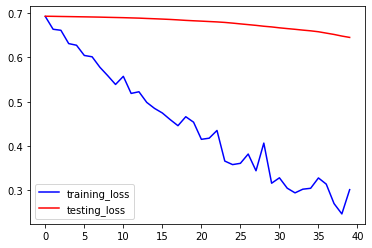

In [ ]:
history = model_1.fit([X_train], Y_train, epochs=40, batch_size=10, validation_split=0.3) #validation_data=(X_test,Y_test)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(loss)), loss, 'b-', label = 'training_loss')
plt.plot(range(len(loss)), val_loss, 'r-', label = 'testing_loss')
plt.legend(loc = 'best')
plt.show()

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.2 MB/s 


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


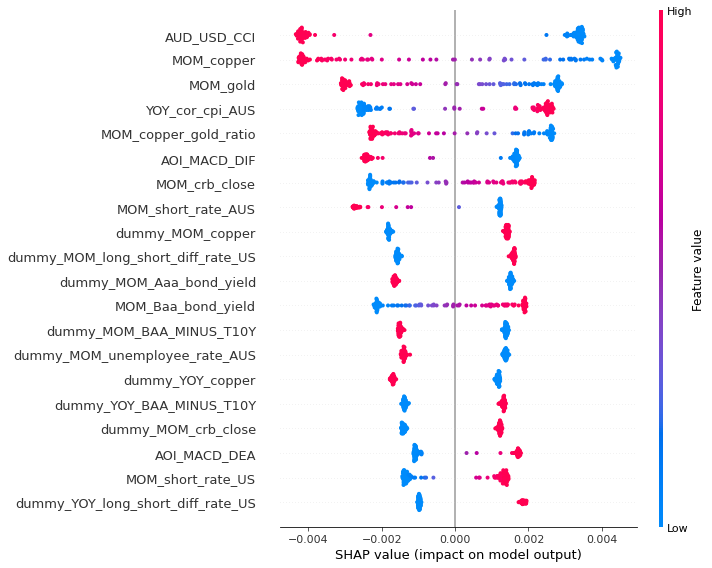

In [ ]:
exp = shap.DeepExplainer(model_1, (X_train))

shap_values = exp.shap_values((X_train))


shap.summary_plot(shap_values[0][:, 2, :], X_train[:, 2, :], feature_names = features_names )

In [ ]:
model_1.save(os.path.join(GOOGLE_DRIVE_PATH,'model_lstm_3M_0529.ht'))

In [ ]:
model_lstm = keras.models.load_model(os.path.join(GOOGLE_DRIVE_PATH,'model_lstm_3M_0529.ht'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


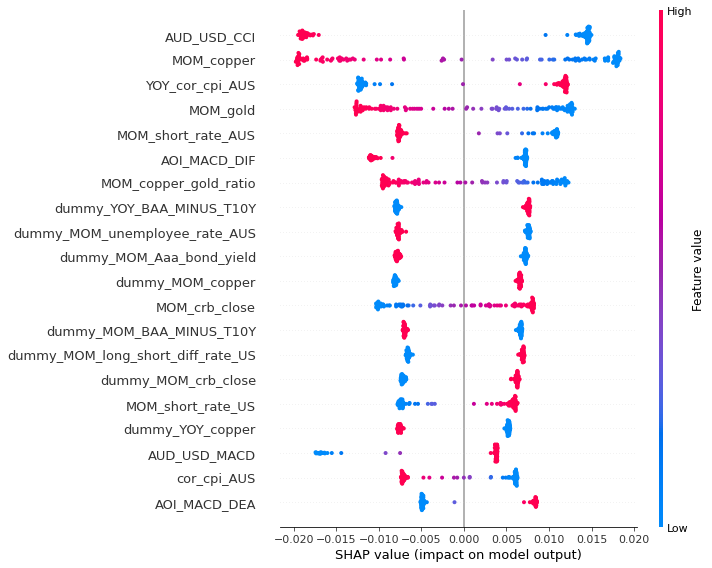

In [ ]:
exp = shap.DeepExplainer(model_lstm, (X_train))

shap_values = exp.shap_values((X_train))


shap.summary_plot(shap_values[0][:, 0, :], X_train[:, 0, :], feature_names = features_names )

In [ ]:
shap_values[0][:,0,:]

array([[ 0.00342638,  0.00184256, -0.00041304, ..., -0.0044831 ,
         0.00113661, -0.00104674],
       [ 0.00370682,  0.00199174, -0.00047348, ...,  0.0015105 ,
         0.0011502 ,  0.0024076 ],
       [ 0.00369   ,  0.00196927, -0.00048705, ...,  0.00145431,
         0.00116889, -0.00240444],
       ...,
       [ 0.0026784 ,  0.00148155, -0.00040982, ..., -0.0043067 ,
         0.00116241,  0.00298379],
       [ 0.00368286,  0.00195407, -0.00058848, ...,  0.0015047 ,
         0.00116722,  0.00347654],
       [ 0.00361652,  0.00190187, -0.00051463, ...,  0.00147   ,
         0.00115209,  0.003468  ]])

In [ ]:
model_lstm.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[0.63344353],
       [0.651719  ],
       [0.525933  ],
       [0.39909318],
       [0.3874451 ],
       [0.43633488],
       [0.40279326],
       [0.37245074],
       [0.44373566],
       [0.35771358],
       [0.44963542],
       [0.3833934 ],
       [0.43078822],
       [0.4850403 ],
       [0.55380255],
       [0.5617839 ],
       [0.5408036 ],
       [0.56361336],
       [0.42796654],
       [0.54588526],
       [0.4116028 ],
       [0.40237972],
       [0.45129895],
       [0.43360153],
       [0.44478813],
       [0.69189125],
       [0.5165356 ],
       [0.45619982],
       [0.40630528],
       [0.5748604 ],
       [0.5829615 ],
       [0.60282505],
       [0.55308115],
       [0.49088857],
       [0.48559248],
       [0.47080892],
       [0.57722896],
       [0.56990963],
       [0.60782176],
       [0.5979688 ],
       [0.5477267 ],
       [0.63430494],
       [0.6626071 ],
       [0.51398873],
       [0.54584557],
       [0.54501265]], dtype=float32)

In [ ]:
def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [ ]:
model_1.predict(X_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


array([[0.63344353],
       [0.651719  ],
       [0.525933  ],
       [0.39909318],
       [0.3874451 ],
       [0.43633488],
       [0.40279326],
       [0.37245074],
       [0.44373566],
       [0.35771358],
       [0.44963542],
       [0.3833934 ],
       [0.43078822],
       [0.4850403 ],
       [0.55380255],
       [0.5617839 ],
       [0.5408036 ],
       [0.56361336],
       [0.42796654],
       [0.54588526],
       [0.4116028 ],
       [0.40237972],
       [0.45129895],
       [0.43360153],
       [0.44478813],
       [0.69189125],
       [0.5165356 ],
       [0.45619982],
       [0.40630528],
       [0.5748604 ],
       [0.5829615 ],
       [0.60282505],
       [0.55308115],
       [0.49088857],
       [0.48559248],
       [0.47080892],
       [0.57722896],
       [0.56990963],
       [0.60782176],
       [0.5979688 ],
       [0.5477267 ],
       [0.63430494],
       [0.6626071 ],
       [0.51398873],
       [0.54584557],
       [0.54501265]], dtype=float32)

In [ ]:
optimal_cutoff = sensivity_specifity_cutoff(Y_test,model_1.predict(X_test))
optimal_cutoff

0.54588526

In [ ]:
pred_y = 1*(model_1.predict(X_test) > optimal_cutoff)
pred_y

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [ ]:
len(pred_y)

46

In [ ]:
print('Train Result:\n')
print(f"Accuracy Score: {accuracy_score(pred_y, Y_test)*100:.2f}%")
print(f"Precision Score: {precision_score(pred_y, Y_test)*100:.2f}%")
print(f"Recall Score: {recall_score(pred_y, Y_test)*100:.2f}%")
print(f"F1 score: {f1_score(pred_y, Y_test)*100:.2f}%")
print('AUC: %.4f' % metrics.roc_auc_score(Y_test,pred_y))
print(f"Confusion Matrix:\n {confusion_matrix(pred_y, Y_test)}")

Train Result:

Accuracy Score: 69.57%
Precision Score: 57.14%
Recall Score: 70.59%
F1 score: 63.16%
AUC: 0.6857
Confusion Matrix:
 [[20  9]
 [ 5 12]]
